In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates
import openpyxl
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from pandas.tseries.offsets import BDay


import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
from pmdarima.arima import auto_arima
import pmdarima as pm

In [3]:
#Import of COVID-19 data from Sciensano & European Commission
import urllib.request
print("Copying files from url...")
print("Copying Cases_AGESEX")
urllib.request.urlretrieve ("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.csv", "C:/Users/KevHa/Desktop/Postgraduate/Dissertation/SourceData/CASES_AGESEX.csv")
print("Copying COVID19 - geo - EC")
urllib.request.urlretrieve ("https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx", "C://Users/KevHa/Desktop/Postgraduate/Dissertation/SourceData/COVID-19-geographic-disbtribution-worldwide.xlsx")

print("Data gathering completed")

Copying files from url...
Copying Cases_AGESEX
Copying COVID19 - geo - EC
Data gathering completed


In [4]:
"""Import of the COVID-19 data and reading the data into a datetime-indexed pandas dataframe"""
file_path = "C://Users/KevHa/Desktop/Postgraduate/Dissertation/SourceData/CASES_AGESEX.csv"

demographics = pd.read_csv(file_path, engine='python')
demographics['DATE'] = pd.to_datetime(demographics['DATE'],infer_datetime_format=True)

demographics_indexed = demographics.set_index(['DATE'])
demographics_indexed.head()

,PROVINCE,REGION,AGEGROUP,SEX,CASES
DATE,,,,,
2020-03-01,Antwerpen,Flanders,40-49,M,1
2020-03-01,Brussels,Brussels,10-19,M,1
2020-03-01,Brussels,Brussels,10-19,F,1
2020-03-01,Brussels,Brussels,20-29,M,1
2020-03-01,Brussels,Brussels,30-39,F,1


In [5]:
"""Removal of obsolete columns, reindex data + applying a 7 days moving average to the data in order to smooth out variations"""
Total_cases = demographics_indexed.groupby('DATE')['CASES'].sum().reset_index(name='CASES')
Total_cases.head()

Total_cases_index = Total_cases.set_index(['DATE'])
#Total_cases.to_excel(r'C:/Users/KevHa/Desktop/Postgraduate/Dissertation/SourceData/output/Total_cases.xlsx')
#Total_cases_index

Total_cases_ma = Total_cases_index.rolling(window=7).mean().fillna(Total_cases_index)
Total_cases_ma

,CASES
DATE,
2020-03-01,17.000000
2020-03-02,17.000000
2020-03-03,36.000000
2020-03-04,55.000000
2020-03-05,81.000000
...,...
2020-06-07,115.857143
2020-06-08,131.285714
2020-06-09,129.142857


                 CASES
DATE                  
2020-06-01  123.142857
2020-06-02  118.142857
2020-06-03  114.000000
2020-06-04  115.000000
2020-06-05  114.142857


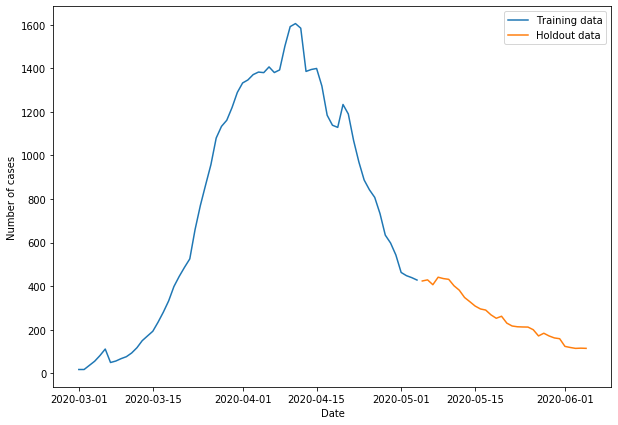

In [44]:
"""Splitting the data in train and test set + plotting both train & holdout set"""
#70-30 train - test set
train=Total_cases_ma[0:65] 
test=Total_cases_ma[65:-6]

fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111)
plt.plot(train, label='Training data')
plt.plot(test, label='Holdout data')
plt.legend(loc="best")
plt.xlabel('Date')
plt.ylabel('Number of cases')

print(test.tail())

            CASES
DATE             
2020-03-01   17.0
2020-03-02    0.0
2020-03-03   19.0
2020-03-04   19.0
2020-03-05   26.0
                CASES
DATE                 
2020-04-30 -54.857143
2020-05-01 -80.285714
2020-05-02 -14.714286
2020-05-03  -9.000000
2020-05-04 -11.142857
            CASES
count   65.000000
mean     6.582418
std     64.111601
min   -198.571429
25%    -25.857143
50%     14.000000
75%     41.857143
max    134.571429


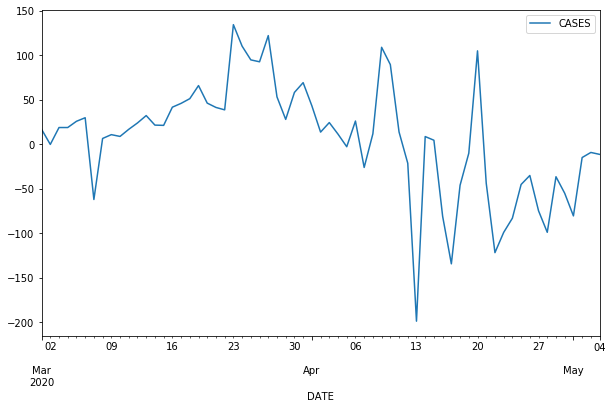

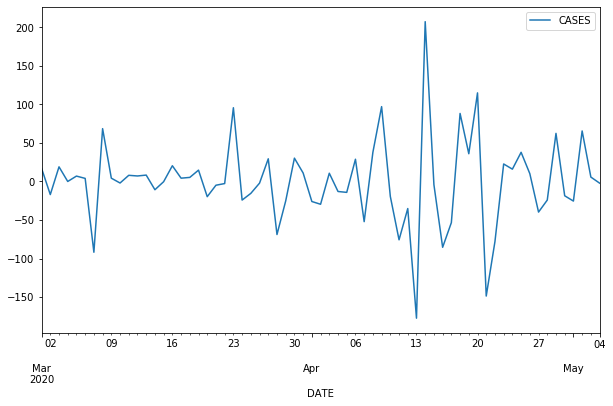

In [42]:
"""First order differencing: Random walk + key statistics"""

train_diff = train.diff().fillna(Total_cases_ma)
#Total_cases_diff1.dropna() -> replaced by fillna to fill empty datafields with undifferenced dataset
train_diff.plot()

#Total_cases_diff1 = Total_cases_diff1.to_frame('CASES')
print(train_diff.head())
print(train_diff.tail())
print(train_diff.describe())

"""Second order differencing"""
#Total_cases_diff1 = Total_cases_index['CASES'] - Total_cases_index['CASES'].shift(1)
train_diff2 = train_diff.diff().fillna(train_diff)
#Total_cases_diff1.dropna()
train_diff2.plot()

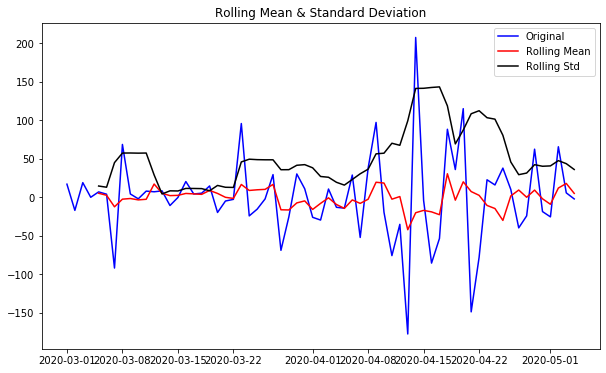

Results of Dickey Fuller Test:
Test Statistic                 -4.149990
p-value                         0.000800
#Lags Used                      6.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [8]:
"""Augemented Dickey-Fuller test for stationarity"""
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=5).mean()
    movingSTD = timeseries.rolling(window=5).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['CASES'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #ADF test Arima 
test_stationarity(train_diff2)

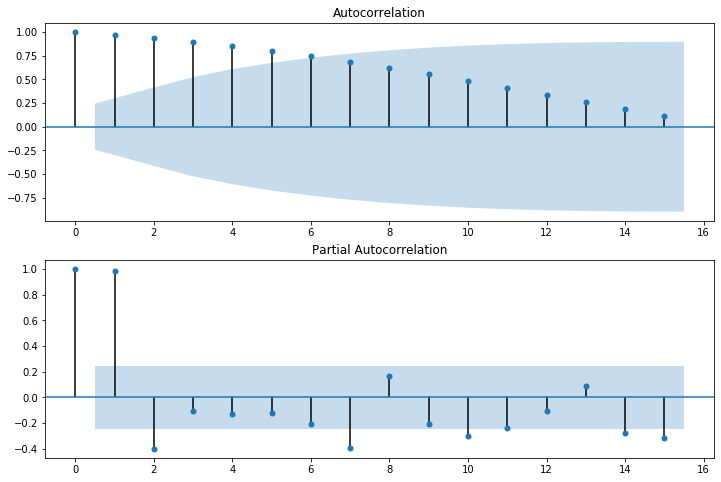

In [9]:
"""ACF & PACF"""
fig = plt.figure(figsize=(12,8))
AC_input = train
ax1 = fig.add_subplot(211)
plot_acf(AC_input, ax=ax1,lags=15)
ax2 = fig.add_subplot(212)
plot_pacf(AC_input, ax=ax2, lags=15)

plt.show()

In [25]:
"""ARIMA(2,2,0) model fitting"""
modelA=ARIMA(train, order=(2,2,0))
ARIMApredict = modelA.fit()
ARIMApredict.summary()

C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.CASES   No. Observations:                   63
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -339.890
Method:                       css-mle   S.D. of innovations             53.215
Date:                Sat, 13 Jun 2020   AIC                            687.780
Time:                        15:02:33   BIC                            696.353
Sample:                    03-03-2020   HQIC                           691.152
                         - 05-04-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2945      4.362     -0.068      0.946      -8.845       8.256
ar.L1.D2.CASES    -0.2508      0.119     -2.101      0.036      -0.485      -0.017
ar.L2.D2.CASES    -0.2997      0.118     -2.544      0.011      -0.530      -0.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4185           -1.7782j            1.8268           -0.2868
AR.2           -0.4185           +1.7782j            1.8268            0.2868
-----------------------------------------------------------------------------
"""

2020-05-05    415.082783
2020-05-06    402.903073
2020-05-07    390.606434
2020-05-08    377.704268
2020-05-09    364.532350
2020-05-10    351.152872
2020-05-11    337.449619
2020-05-12    323.433103
2020-05-13    309.135513
2020-05-14    294.545624
2020-05-15    279.656607
2020-05-16    264.473538
2020-05-17    248.997190
2020-05-18    233.225849
2020-05-19    217.159712
2020-05-20    200.799244
2020-05-21    184.144269
2020-05-22    167.194692
2020-05-23    149.950590
2020-05-24    132.411971
2020-05-25    114.578811
2020-05-26     96.451113
2020-05-27     78.028884
2020-05-28     59.312121
2020-05-29     40.300822
2020-05-30     20.994990
2020-05-31      1.394623
2020-06-01    -18.500278
2020-06-02    -38.689714
2020-06-03    -59.173684
2020-06-04    -79.952188
2020-06-05   -101.025226
Freq: D, dtype: float64


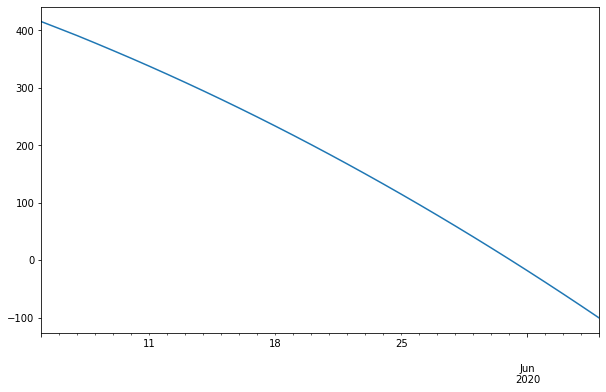

In [45]:
prediction29 = ARIMApredict.predict(start='2020-05-05', end='2020-06-05', typ='levels')
print(prediction29)
prediction29.plot()

In [58]:
"""SARIMA(2,2,0) model fitting"""
model=sm.tsa.statespace.sarimax.SARIMAX(endog=train['CASES'],order=(2,2,0), enforce_invertibility=False)
results=model.fit(transparams=True)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  CASES   No. Observations:                   65
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -339.892
Date:                Sat, 13 Jun 2020   AIC                            685.783
Time:                        16:25:07   BIC                            692.213
Sample:                    03-01-2020   HQIC                           688.312
                         - 05-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2508      0.087     -2.893      0.004      -0.421      -0.081
ar.L2         -0.2996      0.131     -2.281      0.023      -0.557      -0.042
sigma2      2832.1005    350.437      8.082      0.0

C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2020-05-05    415.539646
2020-05-06    404.158681
2020-05-07    392.894793
2020-05-08    381.320968
2020-05-09    369.789785
2020-05-10    358.340765
2020-05-11    346.858367
2020-05-12    335.359723
2020-05-13    323.875153
2020-05-14    312.391921
2020-05-15    300.904137
2020-05-16    289.417093
2020-05-17    277.931228
2020-05-18    266.444845
2020-05-19    254.958239
2020-05-20    243.471844
2020-05-21    231.985463
2020-05-22    220.499015
2020-05-23    209.012580
2020-05-24    197.526161
2020-05-25    186.039735
2020-05-26    174.553305
2020-05-27    163.066879
2020-05-28    151.580453
2020-05-29    140.094026
2020-05-30    128.607599
2020-05-31    117.121172
2020-06-01    105.634746
2020-06-02     94.148319
2020-06-03     82.661892
2020-06-04     71.175465
2020-06-05     59.689038
Freq: D, dtype: float64


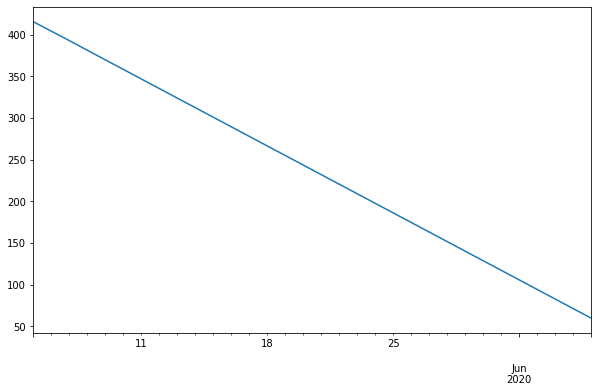

In [59]:
model_29 = results.predict('2020-05-05', '2020-06-05', typ='levels', dynamic=True)
print(model_29)
model_29.plot()

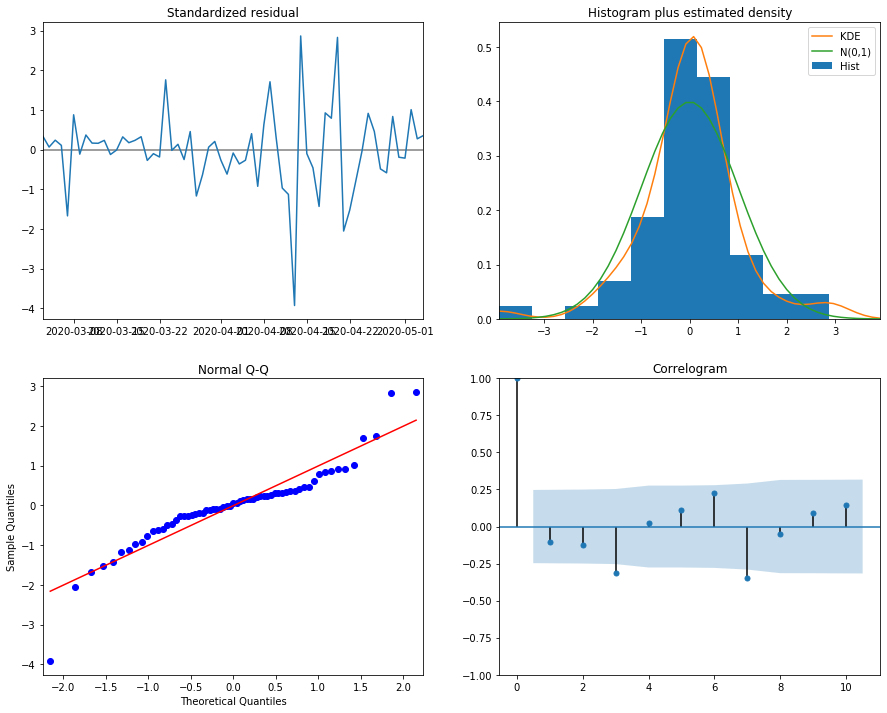

In [60]:
#SARIMA Residuals diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Text(0.5, 1.0, 'SARIMA(2,2,0) Forecast 07-06-2020 - 30-06-2020')

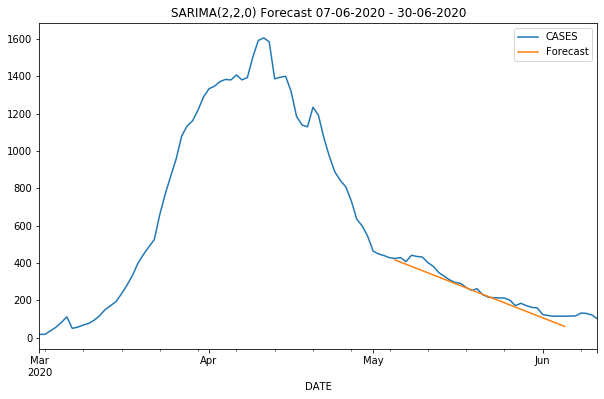

In [49]:
#Forecast beyond holdout set
fig, ax = plt.subplots(sharex='col', sharey='row')
Total_cases_ma.plot(ax=ax, label='Sciensano observations')
model_29.plot(ax=ax, label='Forecast')
#prediction29.plot(ax=ax)
#y_hat.plot(ax=ax)
"""ax.plot(train)
ax.plot(test)"""
plt.legend(loc="best")
ax.set_title('SARIMA(2,2,0) Forecast 07-06-2020 - 30-06-2020')

In [50]:
"""ARIMAX(2,2,0)"""

#Italy cases
#world data retrieved from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/55e8f966-d5c8-438e-85bc-c7a5a26f4863
world = "C://Users/KevHa/Desktop/Postgraduate/Dissertation/SourceData/COVID-19-geographic-disbtribution-worldwide.xlsx"

df_world = pd.read_excel(world,sep=r'\s*,\s*')

df_italy = df_world[df_world['countriesAndTerritories'] == 'Italy']

df_italy = df_italy.set_index('dateRep')
df_italy = df_italy.sort_index(axis=1 ,ascending=True)

df_italy['cumsum_cases'] = df_italy['cases'].cumsum().to_frame()

indexNames = df_italy[df_italy['cases']==0].index
df_italy.drop(indexNames , inplace=True)
df_italy.head()

,cases,continentExp,countriesAndTerritories,countryterritoryCode,day,deaths,geoId,month,popData2018,year,cumsum_cases
dateRep,,,,,,,,,,,
2020-06-13,163,Europe,Italy,ITA,13,56,IT,6,60431283.0,2020,163
2020-06-12,379,Europe,Italy,ITA,12,53,IT,6,60431283.0,2020,542
2020-06-11,202,Europe,Italy,ITA,11,71,IT,6,60431283.0,2020,744
2020-06-10,283,Europe,Italy,ITA,10,79,IT,6,60431283.0,2020,1027
2020-06-09,280,Europe,Italy,ITA,9,65,IT,6,60431283.0,2020,1307


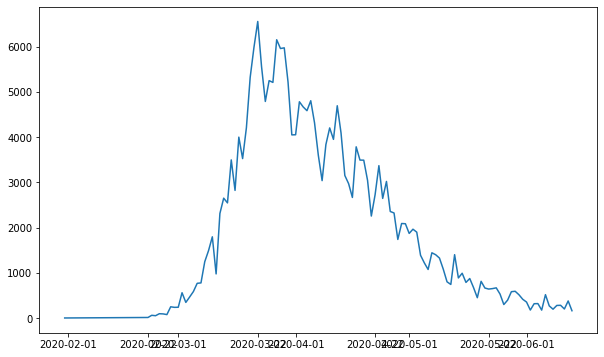

In [51]:
Cases_italy = df_italy['cases']
Cases_italy.to_frame()
plt.plot(Cases_italy)

                 cases
dateRep               
2020-01-31   57.142857
2020-02-22   92.428571
2020-02-23  124.428571
2020-02-24  149.857143
2020-02-25  222.428571
...                ...
2020-06-09  280.000000
2020-06-10  283.000000
2020-06-11  202.000000
2020-06-12  379.000000
2020-06-13  163.000000

[114 rows x 1 columns]


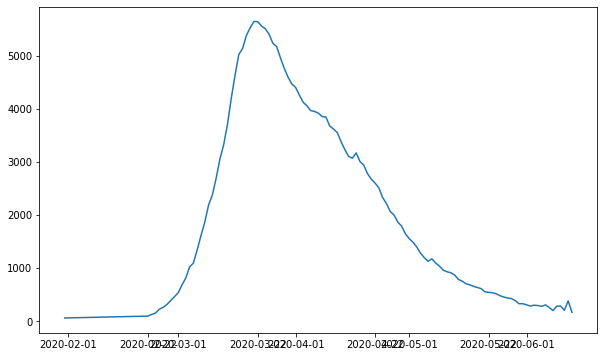

In [33]:
#Rolling mean 7 days 
Cases_italy_ma = Cases_italy.rolling(window=7).mean().fillna(Cases_italy).to_frame()

Italy_reindex = Cases_italy_ma.reindex(index=Cases_italy_ma.index[::-1])
print(Italy_reindex)
plt.plot(Italy_reindex)

In [52]:
#Italy train & test set/holdout set
Italy_train = Italy_reindex['20200301':'20200504']
Italy_train
italy_test = Italy_reindex['20200505':'20200605']
italy_test

,cases
dateRep,
2020-05-05,1193.285714
2020-05-06,1125.142857
2020-05-07,1171.857143
2020-05-08,1092.428571
2020-05-09,1034.000000
2020-05-10,957.142857
2020-05-11,927.428571
2020-05-12,909.285714
2020-05-13,867.428571


In [56]:
#SARIMAX fitting 
model_italy=sm.tsa.statespace.sarimax.SARIMAX(endog=train['CASES'],order=(2,2,0), enforce_invertibility=False, exog=Italy_train['cases'])
results_italy=model_italy.fit()
print(results_italy.summary())

                               SARIMAX Results                                
Dep. Variable:                  CASES   No. Observations:                   65
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -339.389
Date:                Sat, 13 Jun 2020   AIC                            686.778
Time:                        16:24:10   BIC                            695.351
Sample:                    03-01-2020   HQIC                           690.150
                         - 05-04-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cases         -0.0774      0.079     -0.979      0.328      -0.233       0.078
ar.L1         -0.2832      0.085     -3.321      0.001      -0.450      -0.116
ar.L2         -0.3070      0.143     -2.141      0.0

C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\KevHa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2020-05-05    414.150421
2020-05-06    400.497963
2020-05-07    377.596572
2020-05-08    364.174060
2020-05-09    349.316068
2020-05-10    335.920210
2020-05-11    318.804998
2020-05-12    300.802321
2020-05-13    284.654714
2020-05-14    271.773910
2020-05-15    254.840500
2020-05-16    239.315531
2020-05-17    221.434188
2020-05-18    204.315135
2020-05-19    186.510436
2020-05-20    168.783430
2020-05-21    153.988029
2020-05-22    135.486408
2020-05-23    116.630821
2020-05-24     98.737729
2020-05-25     82.139022
2020-05-26     64.688450
2020-05-27     46.640467
2020-05-28     28.116762
2020-05-29     11.628693
2020-05-30     -3.166699
2020-05-31    -22.586527
2020-06-01    -40.368995
2020-06-02    -58.018704
2020-06-03    -78.544856
2020-06-04    -97.555344
2020-06-05   -115.636519
Freq: D, dtype: float64


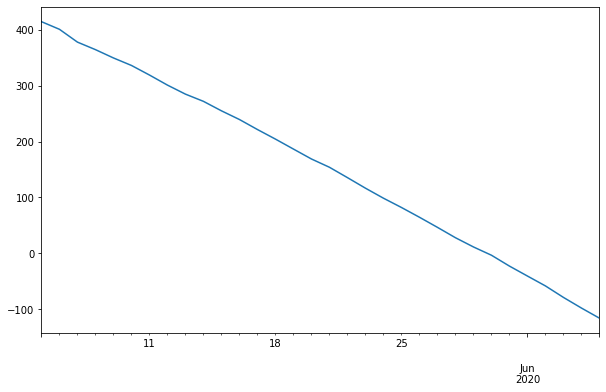

In [21]:
model_italy = results_italy.predict('2020-05-05', '2020-06-05', typ='levels', dynamic=True, exog=italy_test)
print(model_italy)
model_italy.plot()

In [61]:
model_italy_df = model_italy
model_italy_df

ValueError: setting an array element with a sequence.

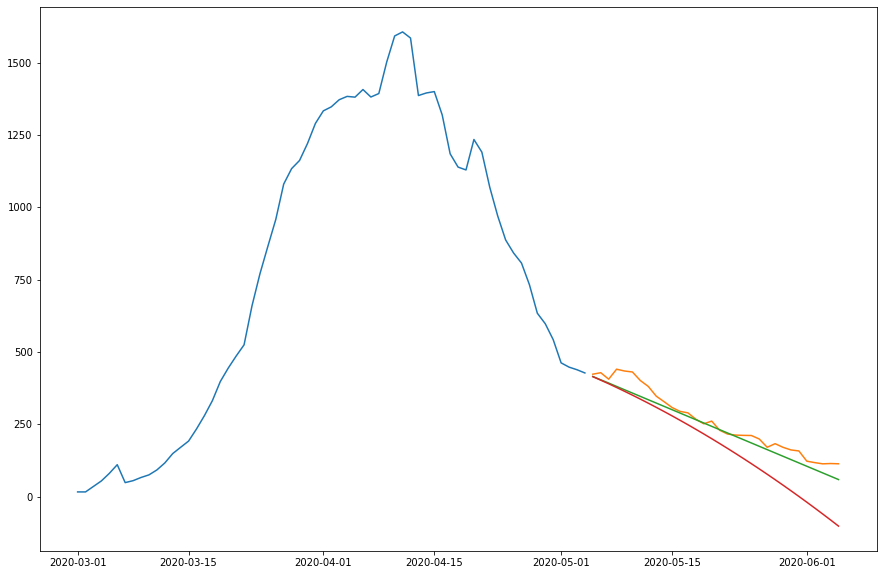

In [62]:
"""End result - Plotting the three models """
fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)
plt.plot(train, label='Training data')
plt.plot(test, label='Holdout data')
plt.plot(model_29, label='SARIMA(2,2,0)')
plt.plot(prediction29, label='ARIMA(2,2,0)')
plt.plot(model_italy_df, label='SARIMAX(2,2,0)')
plt.legend(loc="best")
plt.xlabel('Date')
plt.ylabel('Number of cases')

In [55]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test['CASES'], model_29))

print(mean_absolute_error(test['CASES'], prediction29))
print(mean_absolute_error(test['CASES'], model_italy))

25.744762405414825
83.000191794399


TypeError: Expected sequence or array-like, got <class 'statsmodels.tsa.statespace.sarimax.SARIMAX'>